## AdamW — *Decoupled Weight Decay Regularization*

O **AdamW** é uma modificação do Adam que **desacopla o decaimento de peso (*weight decay*)** do gradiente da perda.  
Enquanto o Adam tradicional mistura o termo de regularização L2 com o gradiente, o AdamW aplica o decaimento separadamente, resultando em melhor generalização.

O SGD com *weight decay* é definido como:

$$
\theta_{t+1} = (1 - \lambda) \, \theta_t - \alpha \, \nabla f_t(\theta_t)
$$

O que equivale a minimizar a função de custo com penalização L2:

$$
\min_\theta \; f_t(\theta) + \frac{\lambda'}{2} \|\theta\|_2^2
$$

onde $\lambda' = \lambda / \alpha$.

No entanto, em otimizadores adaptativos (como o Adam), esse acoplamento causa um erro:  
os pesos com menor gradiente recebem menos regularização, o que distorce o efeito do *weight decay*.

---

### Atualização do AdamW

A atualização padrão do Adam é:

$$
\begin{aligned}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}
\end{aligned}
$$

Com o passo de atualização:

$$
\theta_{t+1} = \theta_t - \eta \, \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \varepsilon}
$$

No AdamW, o *weight decay* é aplicado fora do passo adaptativo:

$$
\theta_{t+1} = \theta_t - \eta \, \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \varepsilon} - \eta \, \lambda \, \theta_t
$$

Essa separação garante que o *weight decay* seja constante por parâmetro e independente do histórico de gradientes.

### Interpretação

- O *learning rate* e o *weight decay* tornam-se hiperparâmetros mais independentes.  
- Melhora a estabilidade e generalização em modelos grandes (ex.: CNNs e Transformers).  

---

## SAM — *Sharpness-Aware Minimization*

O SAM busca minimizar a perda em regiões planas da superfície de otimização,  
em vez de apenas encontrar o ponto de menor perda.  
Isso aumenta a capacidade de generalização do modelo.


### Formulação Min–Max

O objetivo é minimizar a pior perda dentro de uma vizinhança de raio $\rho$:

$$
\min_w \; \max_{\|\varepsilon\|_p \le \rho} \; L_S(w + \varepsilon)
$$

onde $L_S(w) = \frac{1}{n} \sum_i \ell(w; x_i, y_i)$ é a perda média.

### Aproximação do passo adversário

Usando uma expansão de Taylor de primeira ordem, temos:

$$
L_S(w + \varepsilon) \approx L_S(w) + \varepsilon^\top \nabla_w L_S(w)
$$

Maximizando em relação a $\varepsilon$, obtemos o vetor adversário ótimo:

$$
\hat{\varepsilon}(w) = \rho \, \frac{\nabla_w L_S(w)}{\|\nabla_w L_S(w)\|_2}
$$


### Gradiente aproximado do SAM

O gradiente do objetivo suavizado é então aproximado por:

$$
\nabla_w L_S^{\text{SAM}}(w) \approx \nabla_w L_S(w + \hat{\varepsilon}(w))
$$

Na prática, isso leva a dois passos por iteração:

1. Calcular o gradiente e dar um pequeno passo adversário:
   $$
   w' = w + \rho \, \frac{\nabla_w L_S(w)}{\|\nabla_w L_S(w)\|_2}
   $$

2. Calcular novamente o gradiente no ponto perturbado $w'$ e atualizar:
   $$
   w \leftarrow w - \eta \, \nabla_w L_S(w')
   $$

### Interpretação

- O SAM evita soluções muito “agudas” (*sharp minima*).  
- Aumenta a robustez e generalização, especialmente em datasets grandes.  
- Normalmente é usado com AdamW ou SGD como otimizador base.  

---

### Atualização final com SAM + AdamW

$$
\theta_{t+1} = \theta_t - \eta \, \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \varepsilon} - \eta \, \lambda \, \theta_t
\quad \text{com} \quad
g_t = \nabla_\theta L_S(w + \hat{\varepsilon}(w))
$$


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [10]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        if not 0.0 <= rho:
            raise ValueError(f"Invalid rho: {rho}")
        self.rho = rho
        # cria o otimizador base
        self.base_optimizer = base_optimizer(params, **kwargs)
        # inicializa o construtor da superclasse (necessário pro zero_grad funcionar)
        defaults = dict(rho=rho, **kwargs)
        super().__init__(self.base_optimizer.param_groups, defaults)
        # o SAM mantém a mesma lista de grupos de parâmetros
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = torch.norm(
            torch.stack([
                p.grad.norm(p=2) for group in self.param_groups for p in group["params"] if p.grad is not None
            ])
        )
        scale = self.rho / (grad_norm + 1e-12)

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: 
                    continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)
                self.state[p]["e_w"] = e_w

        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: 
                    continue
                p.sub_(self.state[p]["e_w"])
        self.base_optimizer.step()
        if zero_grad:
            self.zero_grad()

    def zero_grad(self):
        self.base_optimizer.zero_grad()

## Lion

O Lion (*Evolved Sign Momentum Optimizer*) é um otimizador recente proposto por Chen et al. (2023) que busca combinar o desempenho de métodos adaptativos (como AdamW) com a simplicidade e eficiência de uso de memória de métodos baseados em sinal, como o *signSGD*.  

Seu nome vem da ideia de usar apenas o sinal do gradiente com momentum, reduzindo a dependência de operações de raiz quadrada e variância, e mantendo um comportamento estável em larga escala.

---

### Motivação

O Adam e outros otimizadores adaptativos apresentam dois problemas práticos:
1. Consomem muita memória, pois armazenam dois momentos (primeiro e segundo) para cada parâmetro.
2. Possuem comportamento sensível ao *weight decay* e às escalas dos gradientes.

O Lion propõe uma atualização mais simples, que mantém a essência do *momentum adaptativo* sem depender da variância dos gradientes.

---

### Atualização do Lion

O Lion mantém um vetor de média móvel do gradiente $m_t$, como o Adam,  
mas a atualização dos pesos depende apenas do sinal de $m_t$:

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$

$$
\theta_{t+1} = \theta_t - \eta \, \text{sign}(m_t) - \eta \, \lambda \, \theta_t
$$

onde:
- $\text{sign}(m_t)$ retorna apenas o sinal de cada componente (+1 ou -1),
- $\eta$ é a taxa de aprendizado,
- $\lambda$ é o *weight decay*,
- $\beta_1$ controla o momentum, e \( \beta_2 \) o amortecimento adicional do histórico.

Na versão final do artigo, o Lion usa uma combinação dupla de momentum:

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
\theta_{t+1} = \theta_t - \eta \, (\text{sign}(m_t) + \beta_2 m_{t-1})
$$


### Intuição

- O sinal do gradiente fornece uma direção robusta,  
  eliminando a influência da magnitude e reduzindo oscilações.
- O momentum acumula a direção predominante do aprendizado.
- Ao misturar ambos, o Lion consegue passos estáveis e consistentes,  
  especialmente em arquiteturas profundas como ViT e modelos de difusão.


### Benefícios

- Baixo custo computacional: não calcula ou armazena o segundo momento.
- Baixo uso de memória: apenas um vetor de momentum por parâmetro.
- Generalização comparável (ou melhor) que AdamW em vários benchmarks.
- Compatível com *weight decay* desacoplado (como no AdamW).




In [11]:
class Lion(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-4, betas=(0.9, 0.99), weight_decay=0.0):
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr, (b1, b2), wd = group["lr"], group["betas"], group["weight_decay"]
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad
                state = self.state[p]

                if len(state) == 0:
                    state["exp_avg"] = torch.zeros_like(p)

                exp_avg = state["exp_avg"]
                exp_avg.mul_(b1).add_(grad, alpha=1 - b1)

                update = exp_avg.sign().add(p, alpha=wd)
                p.add_(update, alpha=-lr)
                exp_avg.mul_(b2).add_(grad, alpha=1 - b2)

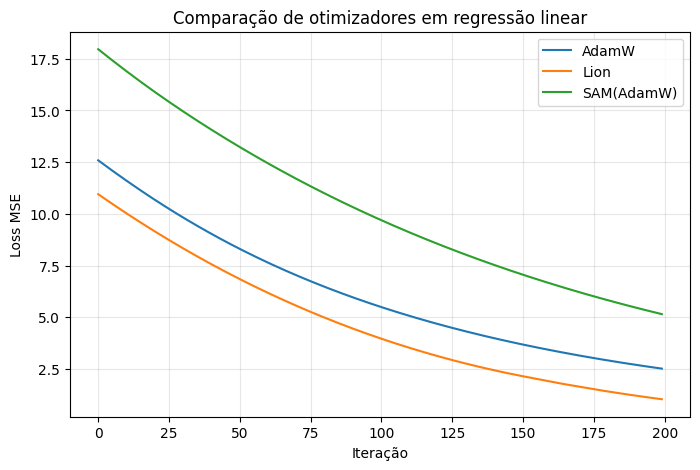

In [ ]:
torch.manual_seed(42)
X = torch.linspace(-2, 2, 200).unsqueeze(1)
y_true = 3 * X + 1 + 0.3 * torch.randn_like(X)

def get_model():
    return nn.Sequential(nn.Linear(1, 1))

def train(model, optimizer, steps=200):
    losses = []
    criterion = nn.MSELoss()
    for _ in range(steps):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y_true)
        loss.backward()
        if isinstance(optimizer, SAM):
            # two-step for SAM
            optimizer.first_step(zero_grad=True)
            criterion(model(X), y_true).backward()
            optimizer.second_step(zero_grad=True)
        else:
            optimizer.step()
        losses.append(loss.item())
    return losses

# 1. AdamW
model_adamw = get_model()
opt_adamw = torch.optim.AdamW(model_adamw.parameters(), lr=1e-2, weight_decay=1e-1)
loss_adamw = train(model_adamw, opt_adamw)

# 2. Lion
model_lion = get_model()
opt_lion = Lion(model_lion.parameters(), lr=1e-2, weight_decay=1e-1)
loss_lion = train(model_lion, opt_lion)

# 3. SAM(AdamW)
model_sam = get_model()
opt_sam = SAM(model_sam.parameters(), torch.optim.AdamW, lr=1e-2, weight_decay=1e-1, rho=0.05)
loss_sam = train(model_sam, opt_sam)

# PLOT
plt.figure(figsize=(8,5))
plt.plot(loss_adamw, label='AdamW')
plt.plot(loss_lion, label='Lion')
plt.plot(loss_sam, label='SAM(AdamW)')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('Otimizadores em regressão linear')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
